In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:200% !important; }</style>"))

In [2]:
import sys  
sys.path.insert(0, '/Users/tigrank/Tigran/programming/cad_parser/bin/')

In [3]:
#driver.find_elements_by_xpath("//select[@name='ddlSearchType']/option[text()='Current Owner']")[0].click()

WARNING *** file size (11274442) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


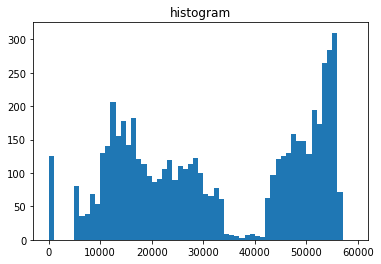

In [23]:
####### Jones county owner's range #######

from fetcher_jones import jones_import_ids
import matplotlib.pyplot as plt

fname = '/Users/tigrank/Tigran/programming/cad_parser/data/data_jones/appraisal_roll.xls'
owner_ids, property_ids = jones_import_ids(fname)
bins = np.arange(1, 60000, 1000)
plt.hist(owner_ids, bins = bins) 
plt.title("histogram") 
plt.show()